## Risk Assessment Notebook

#### Description

The purpose of this notebook is to receive JSON transactions that are stored in Kafka (Azure Event Hub). I created two tables to store the data: `Company` and `Client`. The most important one is the `Client` table.

The idea was to apply Slowly Changing Dimension (SCD) Type 1 to the `Company` table, and a mix of SCD Type 1 and Type 2 to the `Client` table.

##### Achievements:

- **Received JSON transaction files without skipping or loss.**
- **Processed and stored `Company` information using SCD Type 1.**
- **Created a simple dashboard to track `Client` changes.**
- **Verified duplicate transactions** by using a control table `processed_transactions` to ensure that each transaction is processed only once.

##### Areas Not Achieved:

- **Implementing SCD Type 2 for important data in the `Client` table** (code is not working; I wanted to save the history of `credit_rating`, `total_cost`, `risk_score`, `risk_level`, and `approval_status`).
- **Developing a comprehensive dashboard system** (I don't have a Windows laptop to create a Power BI Dashboard that works well with Azure Databricks, so I quickly wrote a simple Matplotlib chart).
- **Handling invalid data** — next steps include validating each column and not updating columns if they contain invalid data (e.g., a `number` instead of a `date`).

### Imports

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import (
  StructType, StructField, 
  StringType, TimestampType, 
  IntegerType, DecimalType, 
  ArrayType, DoubleType,
  DateType, BooleanType
)
from pyspark.sql import Row
from pyspark.sql.utils import AnalysisException
from delta.tables import DeltaTable
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

from decimal import Decimal
from datetime import date  

#### Connection settings

I retrieve secrets that i put in databricks secrets before

In [0]:
EH_NAMESPACE                    = "event-hubs-kafka-namespace"
EH_NAME                         = "kafka-transaction"

EH_CONN_SHARED_ACCESS_KEY_NAME  = "databricks-consumer"
SECRET_SCOPE                    = "databricks-kafka-scope"
EH_CONN_SHARED_ACCESS_KEY_VALUE = dbutils.secrets.get(scope = SECRET_SCOPE, key = EH_CONN_SHARED_ACCESS_KEY_NAME)

EH_CONN_STR                     = f"Endpoint=sb://{EH_NAMESPACE}.servicebus.windows.net/;SharedAccessKeyName={EH_CONN_SHARED_ACCESS_KEY_NAME};SharedAccessKey={EH_CONN_SHARED_ACCESS_KEY_VALUE}"

ehConf = {
  'eventhubs.connectionString' : sc._jvm.org.apache.spark.eventhubs.EventHubsUtils.encrypt(EH_CONN_STR),
  'eventhubs.eventHubName': EH_NAME
}

#### Reading incoming stream from kafka/event-hub

In [0]:
raw_streaming_df = spark.readStream \
    .format("eventhubs") \
    .options(**ehConf) \
    .load()

#### Simple Potential Incoming Json

It's not garantee that all columns will be updated. So it's nullable except the most important one. On a future of company_id for example wasn't sent - drop value, becase json can be broken

In [0]:
#  Example of dummy Json file that I imagined

json_schema = StructType([
    StructField("transaction_id", StringType(), nullable=True),
    StructField("timestamp", TimestampType()),
    StructField("transaction_location", StringType(), nullable=True),
    StructField("company", StructType([
        StructField("company_id", StringType(), nullable=False),
        StructField("company_name", StringType(), nullable=True),
        StructField("address", StringType(), nullable=True),
        StructField("email", StringType(), nullable=True),
        StructField("credit_rating", IntegerType(), nullable=True)
    ]),nullable=True),
    StructField("client", StructType([
        StructField("client_id", StringType(), nullable=False),
        StructField("name", StringType(), nullable=True),
        StructField("email", StringType(), nullable=True),
        StructField("credit_rating", IntegerType(), nullable=True),
        StructField("total_cost", DecimalType(precision=10, scale=2))
    ]),nullable=True),
    StructField("risk_assessment", StructType([
        StructField("client_id", StringType(), nullable=False),
        StructField("risk_score", DoubleType(), nullable=True),
        StructField("risk_level", StringType(), nullable=True),
        StructField("approval_status", StringType(), nullable=True)
    ]),nullable=True)
])

#### Let's get necessary data from json: 'body' and 'timestamp'

In [0]:
# Parse body of incomming Json and take timestamp
json_streaming_df = (
    raw_streaming_df
        .select(
            F.from_json(F.col("body").cast("string"), json_schema).alias("data"),
            F.col('enqueuedTime').alias('timestamp'))
        .select("data.*")
)

#### Let's create if 'processed_transaction' table to store transaction_id and ignore duplicated trnasactions

In [0]:
company_table_path = "/risk_assessment_workspace/company"
processed_transactions_table_path = "/risk_assessment_workspace/processed_transactions"
client_table_path= "/risk_assessment_workspace/client"

#### Processed transaction table in Delta Lake

In [0]:
# `processed_transactions`
# dbutils.fs.rm(processed_transactions_table_path, True)

processed_transaction_schema = StructType([
  StructField("transaction_id", StringType(), False)
])

if not DeltaTable.isDeltaTable(spark, processed_transactions_table_path):
    dbutils.fs.rm(processed_transactions_table_path, True) # In case of there is something else but not Delta Table

    empty_df = spark.createDataFrame([], processed_transaction_schema)
    empty_df.write.format("delta").mode("overwrite").save(processed_transactions_table_path)
    print("Delta table created at path:", processed_transactions_table_path)
else:
    print("Delta table already exists at path:", processed_transactions_table_path)

Delta table created at path: /risk_assessment_workspace/processed_transactions


#### Company table in Delta Lake

In [0]:
# `Company` table
# dbutils.fs.rm(company_table_path, True)

company_schema = StructType([
    StructField("company_id", StringType(), True),
    StructField("company_name", StringType(), True),
    StructField("address", StringType(), True),
    StructField("email", StringType(), True),
    StructField("credit_rating", StringType(), True),
])

if not DeltaTable.isDeltaTable(spark, company_table_path):
    dbutils.fs.rm(company_table_path, True) # In case of there is something else but not Delta Table

    empty_df = spark.createDataFrame([], company_schema)
    empty_df.write.format("delta").mode("overwrite").save(company_table_path)
    print("Delta table created at path:", company_table_path)
else:
    print("Delta table already exists at path:", company_table_path)


Delta table created at path: /risk_assessment_workspace/company


#### Client table in Delta Lake

I tried to generate surrigate key via sql
```python
 spark.sql(
 f"""
     CREATE TABLE IF NOT EXISTS delta.`{client_table_path}`
     (
        client_sk BIGINT GENERATED  BY DEFAULT AS IDENTITY (START WITH 1 INCREMENT BY 1),
        ...

```
But I wasn't successfull when i try to merge client table

In [0]:
# `Client` table
# dbutils.fs.rm(client_table_path, True)

client_schema = StructType([
    StructField("client_sk", IntegerType(), nullable=False),  # Surrogate key should be nullable=False
    StructField("client_id", StringType(), nullable=False),   # Business key should be nullable=False
    StructField("name", StringType(), nullable=True),         # SCD Type 1
    StructField("email", StringType(), nullable=True),        # SCD Type 1
    StructField("credit_rating", IntegerType(), nullable=True),  # SCD Type 2
    StructField("total_cost", DecimalType(10, 2), nullable=True), # SCD Type 2
    StructField("effective_start_date", DateType(), nullable=True),
    StructField("effective_end_date", DateType(), nullable=True),
    StructField("is_current", BooleanType(), nullable=False), # should be nullable=False
    StructField("risk_score", DoubleType(), nullable=True),
    StructField("risk_level", StringType(), nullable=True),
    StructField("approval_status", StringType(), nullable=True)
])

if not DeltaTable.isDeltaTable(spark, client_table_path):
    dbutils.fs.rm(client_table_path, True) # In case of there is something else but not Delta Table

    empty_df = spark.createDataFrame([], client_schema)
    empty_df.write.format("delta").mode("overwrite").save(client_table_path)
    print(f"Delta table created at path: {client_table_path}")
else:
    print(f"Delta table already exists at path: {client_table_path}")

Delta table created at path: /risk_assessment_workspace/client


In [0]:
# global variables that used in `process_microbatch`` function
company_table = DeltaTable.forPath(spark, company_table_path)
processed_transactions_table = DeltaTable.forPath(spark, processed_transactions_table_path)
client_table = DeltaTable.forPath(spark, client_table_path)

def process_microbatch(microbatch_df, batch_id):
    """Process new incoming transactions.
    
    Fetches new incomming transactions from kafka aka azure event-hub and update 'company', 'client', and 'processed_transactions' tables if it's necessary. The idea is to process company in SCD 1 fully, processed_transactions is control table of incomming transaction and ignore income json if transaction_id is the same. And Client should be mix of SCD type 1 and 2.
    """

    processed_transactions_df = processed_transactions_table.toDF()

    new_transactions_df = microbatch_df.join(
        processed_transactions_df,
        on="transaction_id",
        how="left_anti"
    )

    if not new_transactions_df.rdd.isEmpty():
        
        ###########################
        # Company table update logic
        ###########################
        # Flatten company info
        company_updates_df = new_transactions_df.select(
            F.col("company.company_id").alias("company_id"),
            F.col("company.company_name").alias("company_name"),
            F.col("company.address").alias("address"),
            F.col("company.email").alias("email"),
            F.col("company.credit_rating").alias("credit_rating")
        )

        # Merge into the 'company' table (SCD Type 1)
        company_table.alias("target").merge(
            company_updates_df.alias("source"),
            "target.company_id = source.company_id"
        ).whenMatchedUpdate(set={
            "company_name": "source.company_name",
            "address": "source.address",
            "email": "source.email",
            "credit_rating": "source.credit_rating"
        }).whenNotMatchedInsertAll().execute()


        ###########################
        # Process transaction logic
        ###########################
        # Update 'processed_transaction' table
        new_transaction_ids_df = new_transactions_df.select("transaction_id")

        processed_transactions_table.alias("target").merge(
            new_transaction_ids_df.alias("source"),
            "target.transaction_id = source.transaction_id"
        ).whenNotMatchedInsertAll().execute()


        #################################
        # Client table update logic SCD 1
        #################################

        #FIXME: doesn't work - table is empty below
        # Update via SCD Type 1 'name' and 'email'
        client_updates_df = (
            new_transactions_df 
                .withColumn("effective_end_date", F.lit(None).cast(DateType())) 
                .withColumn("is_current", F.lit(True)) 
                .withColumn("effective_start_date", F.col('timestamp').cast(DateType())) 
                .select(
                    F.col("client.client_id").alias("client_id"),
                    F.col("client.name").alias("name"),
                    F.col("client.email").alias("email"),
                    F.col("client.credit_rating").alias("credit_rating"),
                    F.col("client.total_cost").cast(DecimalType(10, 2)).alias("total_cost"),
                    F.col('effective_start_date'),
                    F.col('effective_end_date'),
                    F.col('is_current'),
                    F.col('risk_assessment.risk_score').alias("risk_score"),
                    F.col('risk_assessment.risk_level').alias("risk_level"),
                    F.col('risk_assessment.approval_status').alias("approval_status"),
                )
        )

        # SCD 1: change email and name without creating new row
        client_table.alias("target").merge(
            client_updates_df.alias("source"),
            "target.client_id = source.client_id AND target.is_current = true"
        ).whenMatchedUpdate(set={
            "name": "source.name",
            "email": "source.email"
        }).whenNotMatchedInsert(values={
            "client_id": F.col("source.client_id"),
            "name": F.col("source.name"),
            "email": F.col("source.email"),
            "credit_rating": F.col("source.credit_rating"),
            "total_cost": F.col("source.total_cost"),
            "effective_start_date": F.col("source.effective_start_date"),
            "effective_end_date": F.col("source.effective_end_date"),
            "is_current": F.col("source.is_current"),
            "risk_score": F.col("source.risk_score"),
            "risk_level": F.col("source.risk_level"),
            "approval_status": F.col("source.approval_status"),
        }).execute()

        # FIXME: doesn't work below
        # Next things that needs to be done is apply SCD type 2 on "credit_rating", 
        # "total_cost", increment surrogate_key 'client_sk', and change 'start/end' dates and 'is_current' flag 
        # fetch unchanged data of previous row and create new one

        #################################
        # Client table update logic SCD 2
        #################################
        # Define the columns for SCD Type 2 comparison
        scd2_columns = ["credit_rating", "total_cost", "risk_score", "risk_level", "approval_status"]
        current_client_records_df = client_table.toDF().filter("is_current = true")

        scd2_join_df = current_client_records_df.alias("target").join(
            client_updates_df.alias("source"),
            on="client_id",
            how="inner"
        )

        scd2_condition = " OR ".join([f"target.{col} <> source.{col}" for col in scd2_columns])
        scd2_changed_df = scd2_join_df.filter(scd2_condition)

        if not scd2_changed_df.rdd.isEmpty():
            records_to_expire = scd2_changed_df.select(
                F.col("target.client_sk"),
                F.col("source.effective_start_date").alias("new_effective_end_date")
            )
            
            # Update existing records in bulk using merge
            client_table.alias("target").merge(
                records_to_expire.alias("updates"),
                "target.client_sk = updates.client_sk AND target.is_current = true"
            ).whenMatchedUpdate(set={
                "effective_end_date": "updates.new_effective_end_date",
                "is_current": "false"
            }).execute()

            # Prepare new record via SCD 2
            new_scd2_records_df = scd2_changed_df.select(
                F.col("target.client_sk"),
                F.col("source.client_id"),
                F.col("source.name"),
                F.col("source.email"),
                F.col("source.credit_rating"),
                F.col("source.total_cost"),
                F.col("source.effective_start_date"),
                F.col("source.risk_score"),
                F.col("source.risk_level"),
                F.col("source.approval_status")
            ).withColumn("effective_end_date", F.lit(None).cast("date")) \
            .withColumn("is_current", F.lit(True)) \
            .withColumn("client_sk", F.col("target.client_sk") + 1) \
            .select(
                "client_sk",
                "client_id", "name", "email",
                "credit_rating", "total_cost",
                "effective_start_date", "effective_end_date", "is_current",
                "risk_score", "risk_level", "approval_status"
            )

            new_scd2_records_df.write.format("delta").mode("append").save(client_table_path)


# Start the streaming query
json_stream = (
    json_streaming_df.writeStream
    .foreachBatch(process_microbatch)
    .outputMode("append")
    .option("checkpointLocation", "/mnt/risk_assessment_workspace/checkpoints/transaction_checkpoint")
    .start()
)

display(json_stream)

In [0]:
processed_transactions_df = spark.read.format("delta").load(processed_transactions_table_path)

# Display the contents
processed_transactions_df.show(truncate=False)

+--------------+
|transaction_id|
+--------------+
|1111          |
|2222          |
+--------------+



In [0]:
# Read the company Delta table
company_df = spark.read.format("delta").load(company_table_path)

# Display the contents
company_df.show(truncate=False)

+----------+---------------------+-------------------------------------------------+-------------------------------+-------------+
|company_id|company_name         |address                                          |email                          |credit_rating|
+----------+---------------------+-------------------------------------------------+-------------------------------+-------------+
|111       |Shadow Enterprises   |0000 Nowhere Lane, Imaginary City, ZZ, 00000, USA|ghost@shadowenterprises.biz    |300          |
|22        |Global Tech Solutions|4567 Innovation Park, New York, NY, 10002, USA   |contact@globaltechsolutions.com|750          |
+----------+---------------------+-------------------------------------------------+-------------------------------+-------------+



#### Client table in Delta Lake  (doesn't work)

In [0]:
# Read the client Delta table
client_df = spark.read.format("delta").load(client_table_path)

# Display the contents
client_df.show(truncate=False)

+---------+---------+----+-----+-------------+----------+--------------------+------------------+----------+----------+----------+---------------+
|client_sk|client_id|name|email|credit_rating|total_cost|effective_start_date|effective_end_date|is_current|risk_score|risk_level|approval_status|
+---------+---------+----+-----+-------------+----------+--------------------+------------------+----------+----------+----------+---------------+
+---------+---------+----+-----+-------------+----------+--------------------+------------------+----------+----------+----------+---------------+



#### It didn't work so i will emulate 'client' table

In [0]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DecimalType, DateType, BooleanType, DoubleType
from datetime import date
from decimal import Decimal

# Define the schema as per your updated client_schema with the new columns
client_schema = StructType([
    StructField("client_sk", IntegerType()),  # Surrogate key
    StructField("client_id", StringType()),   # Business key
    StructField("name", StringType()),         # SCD Type 1
    StructField("email", StringType()),        # SCD Type 1
    StructField("credit_rating", IntegerType()),  # SCD Type 2
    StructField("total_cost", DecimalType(10, 2)), # SCD Type 2
    StructField("effective_start_date", DateType()),
    StructField("effective_end_date", DateType()),
    StructField("is_current", BooleanType()), # Redundant column to ensure latest actual value
    StructField("risk_score", DoubleType()), # SCD Type 2
    StructField("risk_level", StringType()),  # SCD Type 2
    StructField("approval_status", StringType()), # SCD Type 2
])

# Sample data with the new columns
sample_data = [
    # Alice
    Row(client_sk=1, client_id="C001", name="Alice", email="alice@example.com",
        credit_rating=700, total_cost=Decimal('1000.00'),
        effective_start_date=date(2023, 9, 20), effective_end_date=date(2023, 9, 23), is_current=False,
        risk_score=8.5, risk_level="Low", approval_status="Approved"),
        
    Row(client_sk=2, client_id="C001", name="Alice", email="alice@example.com",
        credit_rating=710, total_cost=Decimal('2000.00'),
        effective_start_date=date(2023, 9, 23), effective_end_date=date(2023, 9, 24), is_current=False,
        risk_score=7.8, risk_level="Medium", approval_status="Approved"),
        
    Row(client_sk=3, client_id="C001", name="Alice", email="alice@example.com",
        credit_rating=500, total_cost=Decimal('10000.00'),
        effective_start_date=date(2023, 9, 24), effective_end_date=None, is_current=True,
        risk_score=2.3, risk_level="High", approval_status="Pending"),

    # Bob
    Row(client_sk=4, client_id="C002", name="Bob", email="bob@example.com",
        credit_rating=650, total_cost=Decimal('500.00'),
        effective_start_date=date(2023, 8, 21), effective_end_date=date(2023, 9, 21), is_current=False,
        risk_score=5.6, risk_level="Medium", approval_status="Approved"),
        
    Row(client_sk=5, client_id="C002", name="Bob", email="bob_new@example.com",
        credit_rating=1000, total_cost=Decimal('1000.00'),
        effective_start_date=date(2023, 9, 21), effective_end_date=None, is_current=True,
        risk_score=9.0, risk_level="Low", approval_status="Approved"),

    # Charlie
    Row(client_sk=6, client_id="C003", name="Charlie", email="charlie@example.com",
        credit_rating=720, total_cost=Decimal('750.00'),
        effective_start_date=date(2023, 9, 22), effective_end_date=None, is_current=True,
        risk_score=7.0, risk_level="Medium", approval_status="Approved"),

    Row(client_sk=7, client_id="C003", name="Charlie", email="charlie@example.com",
        credit_rating=720, total_cost=Decimal('900.00'),
        effective_start_date=date(2023, 9, 22), effective_end_date=date(2023, 9, 25), is_current=False,
        risk_score=7.2, risk_level="Medium", approval_status="Approved"),

    Row(client_sk=8, client_id="C003", name="Charlie", email="charlie@example.com",
        credit_rating=720, total_cost=Decimal('1200.00'),
        effective_start_date=date(2023, 9, 26), effective_end_date=None, is_current=True,
        risk_score=8.1, risk_level="Low", approval_status="Approved"),

    # Diana
    Row(client_sk=9, client_id="C004", name="Diana", email="diana@example.com",
        credit_rating=680, total_cost=Decimal('800.00'),
        effective_start_date=date(2023, 9, 24), effective_end_date=None, is_current=True,
        risk_score=6.5, risk_level="Medium", approval_status="Approved"),

    # Diana
    Row(client_sk=10, client_id="C005", name="Eve", email="eve@example.com",
        credit_rating=690, total_cost=Decimal('900.00'),
        effective_start_date=date(2023, 9, 25), effective_end_date=None, is_current=True,
        risk_score=9.8, risk_level="High", approval_status="Approved"),
]

# Create DataFrame with the sample data
sample_df = spark.createDataFrame(sample_data, schema=client_schema)

# Define the path where you want to store the Delta table
client_table_path = "/path/to/delta/client_table"

# Write the DataFrame into the Delta table (overwrite existing data)
sample_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(client_table_path)

print("Sample data has been written to the client Delta table.")

# Read back the data to verify
client_df = spark.read.format("delta").load(client_table_path)
client_df.orderBy(["client_id","client_sk"]).show(truncate=False)

Sample data has been written to the client Delta table.
+---------+---------+-------+-------------------+-------------+----------+--------------------+------------------+----------+----------+----------+---------------+
|client_sk|client_id|   name|              email|credit_rating|total_cost|effective_start_date|effective_end_date|is_current|risk_score|risk_level|approval_status|
+---------+---------+-------+-------------------+-------------+----------+--------------------+------------------+----------+----------+----------+---------------+
|        1|     C001|  Alice|  alice@example.com|          700|   1000.00|          2023-09-20|        2023-09-23|     false|       8.5|       Low|       Approved|
|        2|     C001|  Alice|  alice@example.com|          710|   2000.00|          2023-09-23|        2023-09-24|     false|       7.8|    Medium|       Approved|
|        3|     C001|  Alice|  alice@example.com|          500|  10000.00|          2023-09-24|              null|      true

In [0]:

alice_df = (
    client_df
        .filter(F.col("client_id") == "C001")
            .orderBy(F.col("effective_start_date"), ascending=True)
            .select(
            F.col("effective_start_date"),
            F.col("credit_rating").alias("credit_rating")
        )
)

# Show Alice's records
alice_df.show(truncate=False)

+--------------------+-------------+
|effective_start_date|credit_rating|
+--------------------+-------------+
|2023-09-20          |700          |
|2023-09-23          |710          |
|2023-09-24          |500          |
+--------------------+-------------+



#### Let's create super simple chat that shows one user's credit rating

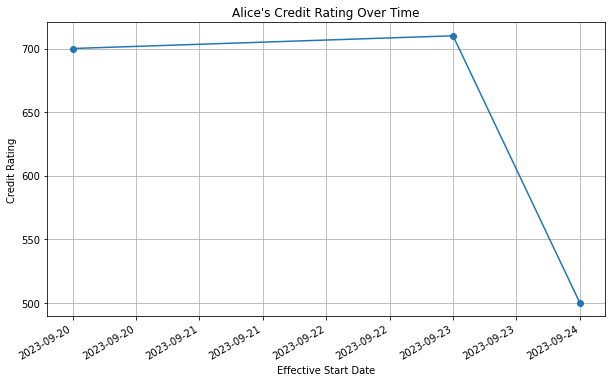

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the DataFrame to Pandas for plotting
alice_risk_pd = alice_df.toPandas()

# Convert effective_start_date to datetime if necessary
alice_risk_pd['effective_start_date'] = pd.to_datetime(alice_risk_pd['effective_start_date'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(alice_risk_pd['effective_start_date'], alice_risk_pd['credit_rating'], marker='o', linestyle='-')
plt.title("Alice's Credit Rating Over Time")
plt.xlabel('Effective Start Date')
plt.ylabel('Credit Rating')
plt.grid(True)

# Format the x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels

# Display the plot
plt.show()


#### Conclusion

I covered the most important requirements, and there is room for improvement. 😊